In [1]:
x=[]
y=[]
c=0
import numpy as np
import os
temp = np.load('/kaggle/input/contrails-images-ash-color/contrails/1000216489776414077.npy')
print(temp.shape)
for file in os.listdir("/kaggle/input/contrails-images-ash-color/contrails"):
    if(c<1000): #Initially Considering Only 1000 Images. Will Be Scaling Up Later.
        a=np.load("/kaggle/input/contrails-images-ash-color/contrails/"+file)
        xa=a[:,:,:3]
        ya=a[:,:,3]
        temp = np.sum(ya)
        if(temp>0):
            x.append(xa.astype('float32'))
            y.append(ya.astype(np.bool))
            c+=1

(256, 256, 4)


/tmp/ipykernel_28/1623699454.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y.append(ya.astype(np.bool))


In [2]:
x=np.array(x)
y=np.array(y)

In [3]:
x.shape
y.shape

(1000, 256, 256)

In [4]:
y=y.reshape(1000,256,256,1)

In [5]:
y.shape

(1000, 256, 256, 1)

In [19]:
y.dtype

dtype('bool')

In [6]:
from skimage.io import imread,imshow

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


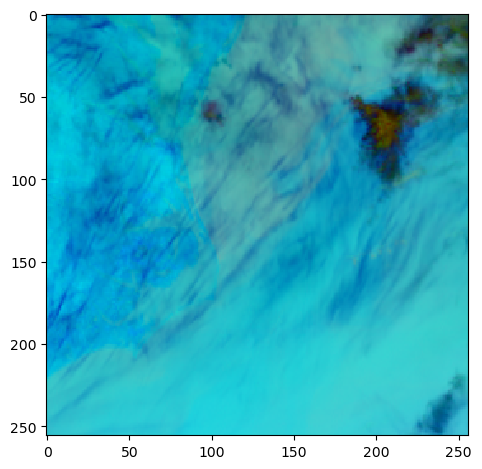

In [7]:
imshow(x[1])

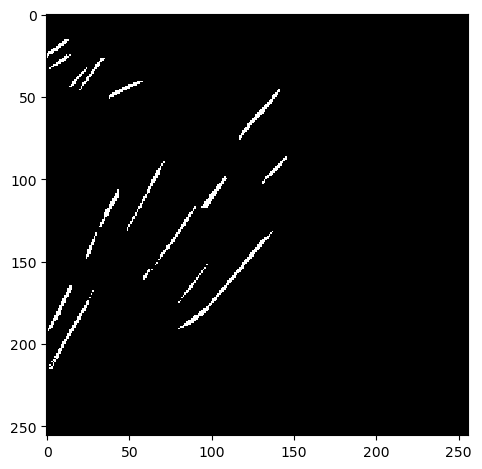

In [8]:
imshow(y[1])

In [9]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=0)
print('Training Set Size ',len(xtrain))
print('Testing Set Size ',len(xtest))

Training Set Size  800
Testing Set Size  200


In [21]:
import tensorflow as tf
from tensorflow import keras
from keras.models import *
from keras.layers import *
import numpy as np
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Input, Cropping2D, Flatten
from keras.models import Model
from tensorflow import keras
def conv(inputs, num_filters):
    x = Conv2D(num_filters,(3,3), activation="relu", 
                               kernel_initializer="he_normal", padding="same")(inputs)
    #x = Dropout(0.1)(x)
    x = Conv2D(num_filters, (3, 3), activation="relu", 
                               kernel_initializer="he_normal", padding="same")(x)
    return x
def deconv(inputs, conv_prev, num_filters):
    up = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    concat =  tf.keras.layers.concatenate([up, conv_prev])
    conva = conv(concat, num_filters)
    return conva
inputs = Input((256, 256, 3))
c1=conv(inputs,64)
p1=MaxPooling2D((2,2))(c1)
c2=conv(p1,128)
p2=MaxPooling2D((2,2))(c2)
c3=conv(p2,256)
p3=MaxPooling2D((2,2))(c3)
c4=conv(p3,512)
p4=MaxPooling2D((2,2))(c4)
c5=conv(p4,1024)

c6 = deconv(c5, c4, 512)
c7 = deconv(c6, c3, 256)
c8 = deconv(c7, c2, 128)
c9 = deconv(c8, c1, 64)
op= Conv2D(1,(1,1), activation='sigmoid',padding='same')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[op])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_19[0][0]']              
                                )                                                           

In [22]:
results = model.fit(
    xtrain, 
    ytrain, 
    validation_split = 0.1, 
    batch_size = 16, 
    epochs = 10)

Epoch 1/10
45/45 [==============================] - 41s 749ms/step - loss: 0.0937 - accuracy: 0.9741 - val_loss: 0.0706 - val_accuracy: 0.9868
Epoch 2/10
45/45 [==============================] - 31s 699ms/step - loss: 0.0647 - accuracy: 0.9880 - val_loss: 0.0661 - val_accuracy: 0.9868
Epoch 3/10
45/45 [==============================] - 31s 696ms/step - loss: 0.0615 - accuracy: 0.9880 - val_loss: 0.0646 - val_accuracy: 0.9868
Epoch 4/10
45/45 [==============================] - 32s 714ms/step - loss: 0.0594 - accuracy: 0.9880 - val_loss: 0.0677 - val_accuracy: 0.9868
Epoch 5/10
45/45 [==============================] - 32s 704ms/step - loss: 0.0572 - accuracy: 0.9880 - val_loss: 0.0582 - val_accuracy: 0.9868
Epoch 6/10
45/45 [==============================] - 32s 704ms/step - loss: 0.0541 - accuracy: 0.9880 - val_loss: 0.0567 - val_accuracy: 0.9868
Epoch 7/10
45/45 [==============================] - 32s 711ms/step - loss: 0.0541 - accuracy: 0.9880 - val_loss: 0.0598 - val_accuracy: 0.9868

In [ ]:
model.save('cnn_semantics.h5')

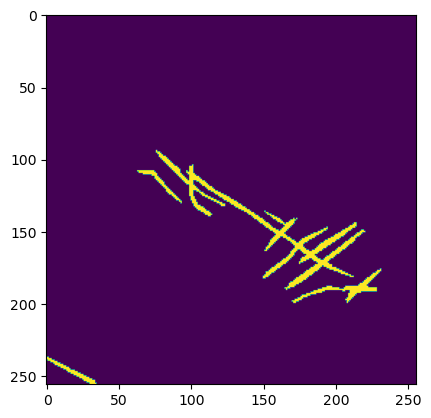

In [23]:
import matplotlib.pyplot as plt
xt=xtest[13]
yt=ytest[13]

plt.imshow(yt)

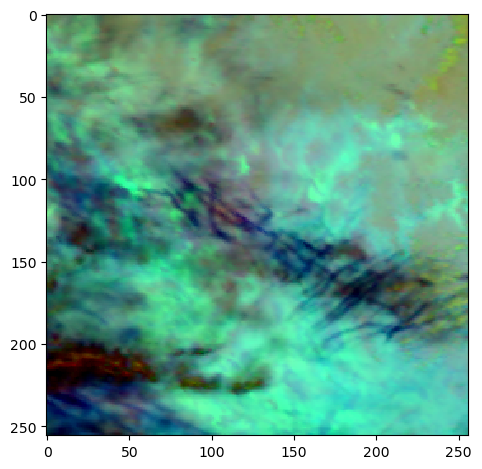

In [24]:
imshow(xt)

In [50]:
test_loss, test_acc = model.evaluate(xtest,ytest, verbose=2)
print(test_acc)


7/7 - 23s - loss: 0.0475 - accuracy: 0.9884 - 23s/epoch - 3s/step
0.9883792400360107


In [25]:
xt=np.expand_dims(xt,axis=0)
print(xt.shape)
xt1 = xtest[100]
print(xt1.shape)

(1, 256, 256, 3)
(256, 256, 3)


In [26]:
prediction = model.predict(xt,verbose=1)


1/1 [==============================] - 0s 250ms/step


In [53]:
prediction=(prediction).astype(float)

In [18]:
np.sum(prediction)

65536.0

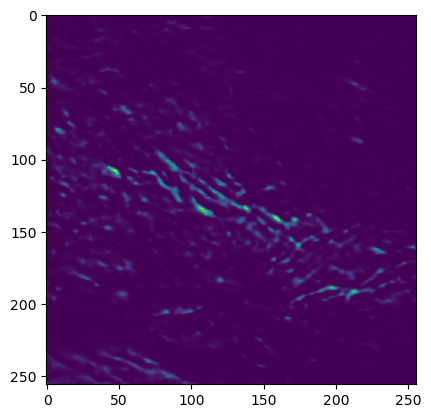

In [28]:
plt.imshow(np.squeeze(prediction))

In [31]:
np.min(prediction)

2.6821508e-07

In [61]:
m=np.sum(prediction)/(256*256)
m

0.005835481886776961

In [62]:
prediction[prediction<m]=0

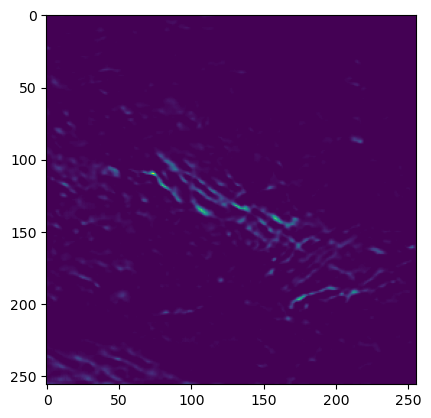

In [63]:
plt.imshow(prediction[0])
